In [ ]:
import numpy as np

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
def plot_distribution(ax, pdfs, title=''): 
    x = np.linspace(0., 10., 200)
    ymax = 0    
    for index, pdf in enumerate(pdfs):
        y = norm.pdf(x, pdf.mean, np.sqrt(pdf.var))

        p = ax.plot(x, y, lw = 2)
        c = p[0].get_markeredgecolor()    
        ax.fill_between(x, y, 0, color=c, alpha=0.2 )    
        ax.autoscale(tight=True)
        ax.vlines(pdf.mean, 0, y.max(), colors = c, linestyles = "--", lw = 2)    

        ymax = max( ymax, y[1:].max()*1.05 )
    ax.set_ylim([0,ymax])

def plot_regret(ax, regret, title=''): 
    ax.plot(regret)

def plot(regret, mab):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    plot_regret(axs[0], regret)
    plot_distribution(axs[1], mab)

In [ ]:
class Arm:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var

    def sample(self):
        return np.random.normal(self.mean, np.sqrt(self.var))

    def name(self):
        return 'N(' + str(self.mean) + ',' + str(self.var) + ')'

# Thompson Sampling

In this exercise we will run thompson sampling for 2-armed bandit with gaussian distribution.
For simplicity assume we know variance of distribution of arms and only mean is unknown
for prior assume gaussian distribution.

## 1.
if variance was unknown what prior distribtion would be suitable? **One suitable distribution can be normal-inverse-gamma distribution. This distribution is a conjugate prior to the normal distribution with unknown mean and variance**


## 2.
Implement Thompson Sampling algorithm. For comparison also implement ϵ-Greedy and UCB algorithms

In [ ]:
class ThompsonSampling:
    def __init__(self, var_list, **kwargs):
        """
        variance of arms are known to policy
        """
        self.var_list = var_list
        self.mean_list = [0]*len(var_list)
        self.visited = [0]*len(var_list)
        self.Qs = [0] * len(var_list)
        self.t0 = [0.0001] * len(var_list)

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        
        # select arm based on estimate of prior distribution
        actions =  [np.random.normal(self.mean_list[i], np.sqrt(self.var_list[i])) for i in range(len(self.var_list))]
        return np.argmax(actions)
        # return index of selected arm

        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        
        # update prior based on reward
        self.visited[idx] += 1
        n = self.visited[idx]
        self.Qs[idx] = (1 - 1.0/n) * self.Qs[idx] + (1.0/n) * reward # Q is mean of all rewards so far
        self.mean_list[idx] = ((self.t0[idx] * self.mean_list[idx]) + (n * self.Qs[idx]))/(self.t0[idx] + n)        
        self.t0[idx] += 1
        # ==================================== Your Code (End) ====================================
    

In [ ]:
        
import math
class UCB:    
    def __init__(self, n_bandits, c_level):
        """
        c_level: coefficient of uncertainty
        """
        self.c_level = c_level 
        self.n_bandits = n_bandits
        self.rewards = [0] * n_bandits
        self.visited = [0] * n_bandits

    
    def select_arm(self, t):
        """
        t: step time
        """
        # ==================================== Your Code (Begin) ==================================
        
        # select arm based on UCB
        for i in range(self.n_bandits):
            if not self.visited[i]:
                return i 
        scores = [0.0] * self.n_bandits
        for i in range(self.n_bandits):
            score = self.rewards[i] + self.c_level * np.sqrt(np.log(t)/self.visited[i])
            scores[i] = score
        max_ucb = max(scores)
        valid_results = [i for i in range(self.n_bandits) if scores[i]==max_ucb]
        return np.random.choice(valid_results)

        # return index of selected arm

        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        self.visited[idx] += 1
        n = self.visited[idx]
        self.rewards[idx] = ((n-1)*self.rewards[idx] + reward)/n
        # update based on reward
        
        # ==================================== Your Code (End) ====================================
        

In [ ]:
import random 

class eGreedy:    
    def __init__(self, n_bandits, epsilon):
        """
        epsilon must be given
        """
        self.epsilon = epsilon
        self.n_bandits = n_bandits
        self.rewards = [0] * n_bandits
        self.visited = [0] * n_bandits
    
    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        if random.random() < self.epsilon:
            return np.random.randint(self.n_bandits)
        all_valid_results = [i for i in range(self.n_bandits) if self.rewards[i]==max(self.rewards)]
        return np.random.choice(all_valid_results)
        # select arm based on e-Greedy
        
        # return index of selected arm

        # ==================================== Your Code (End) ====================================


    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        
        # update based on reward
        self.visited[idx] += 1 
        count = self.visited[idx]
        self.rewards[idx] = ((count-1)*self.rewards[idx] + reward)/ count
        # ==================================== Your Code (End) ====================================
        

## 3
run simulation for arms described as cells below and describe the differences of regret with different variance in arms distributions

rum_sim1 must return cumulitive regret formulated as 
$$
R(T)=\sum_{i=1}^2 N_i(T) \Delta_i
$$

where $N_i(T)$ is number of times arm $i$ was selected until step $T$, $\Delta_i=\mu^*-\mu_i$, $\mu^*$ is largest mean in arms distribtions and $\mu_i$ is mean of distribution of arm $i$

to get average regret we rum simulation 50 times.

In [ ]:
def run_sim1(policy, mab, step_num=100):
    """
    run simulation of multi-armed bandit
    mab: list of arms
    """
    best_mean = np.max([b.mean for b in mab])
    regret = []
    action = [0, 0]
    for k in range(step_num):          
        # ==================================== Your Code (Begin) ==================================
        selected_arm = policy.select_arm(k)
        reward = mab[selected_arm].sample()
        policy.update(selected_arm, reward)
        reg = best_mean - mab[selected_arm].mean
        action [selected_arm] += 1
        regret.append(action[selected_arm]*reg)
        # run policy algorithm and return cumulative regret
        # ==================================== Your Code (End) ====================================
    return regret

### 3.1
Assume Multi-Armed Bandit variables are as follows.

In [ ]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]

#### Thompson Sampling
run and describe the result.

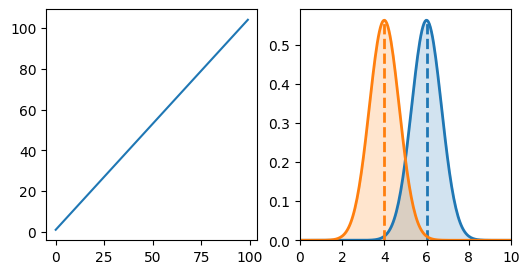

In [ ]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

#### ϵ-Greedy
run for different values of ϵ and compare results.

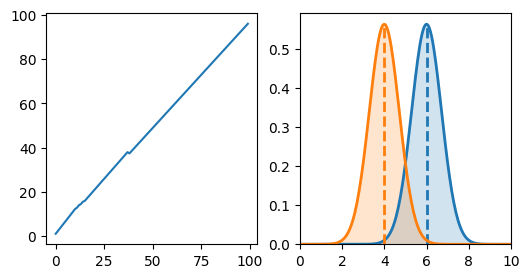

In [ ]:
epsilon = 0.002
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

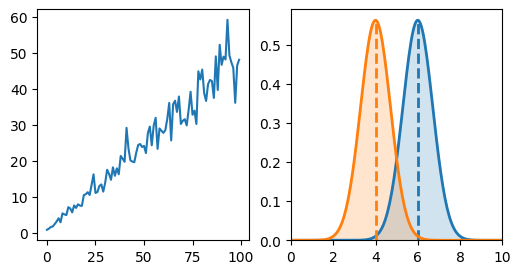

In [ ]:
epsilon = 1
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

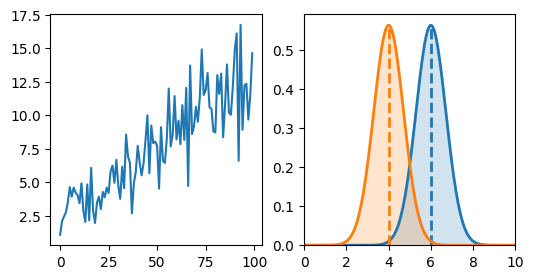

In [ ]:
epsilon = 0.5
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

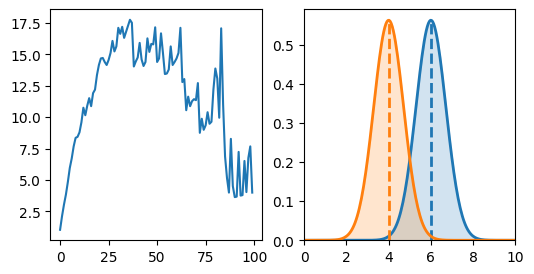

In [ ]:
epsilon = 0.05
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

#### UCB
run for different values of confidence level and compare results.


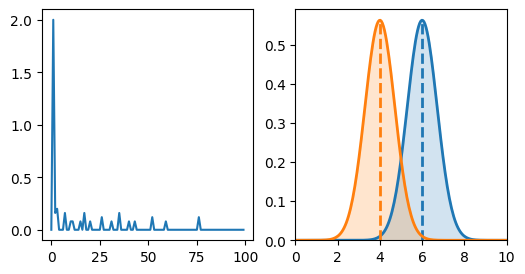

In [ ]:
c_level = 1
regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

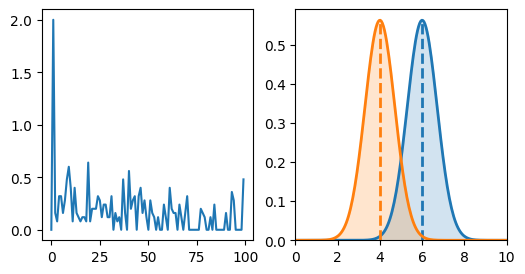

In [ ]:
c_level = 2
regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

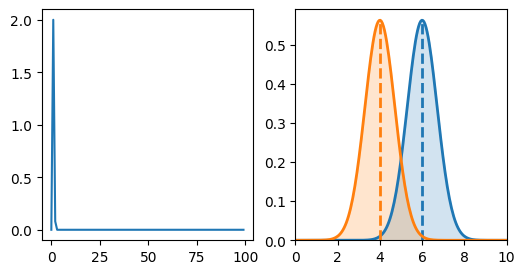

In [ ]:
c_level = 0.1
regret = [run_sim1(UCB(2, c_level=c_level), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

### 3.2
Assume Multi-Armed Bandit variables are as follows.

In [ ]:
mab = [Arm(6, 10), Arm(4, 10)]

#### Thompson Sampling
run and compare results.

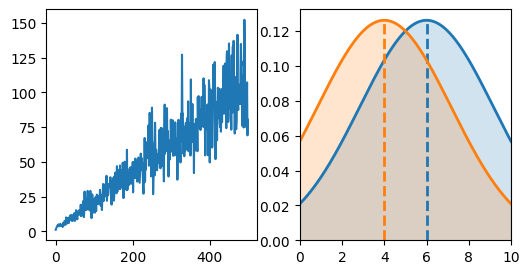

In [ ]:
regret = [run_sim1(ThompsonSampling([b.var for b in mab]), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

#### ϵ-Greedy
run for different values of ϵ and compare results.

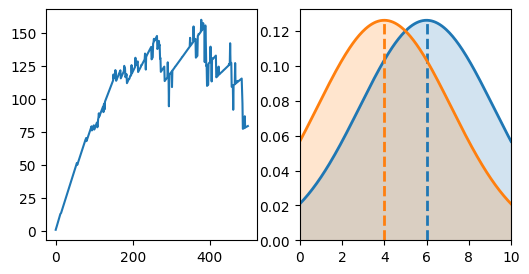

In [ ]:
epsilon = 0.01
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

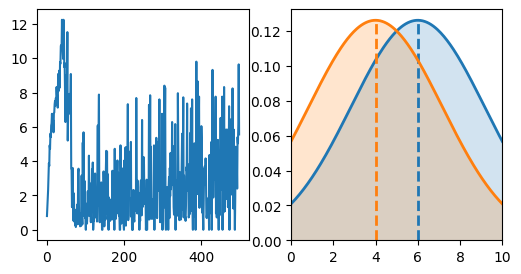

In [ ]:
epsilon = 0.1
regret = [run_sim1(eGreedy(2, epsilon=epsilon), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

#### UCB
run for different values of confidence level and compare results.

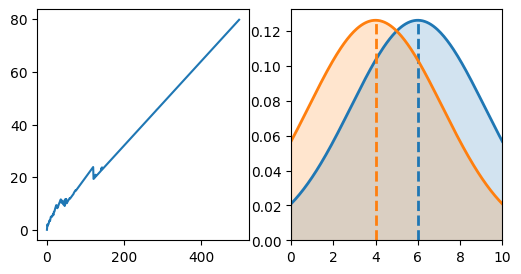

In [ ]:
c_level = 1
regret = [run_sim1(UCB(2, c_level=c_level), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

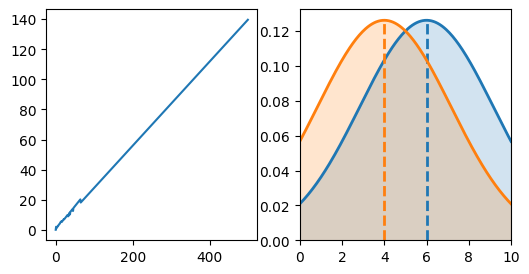

In [ ]:
c_level = 0.1
regret = [run_sim1(UCB(2, c_level=c_level), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

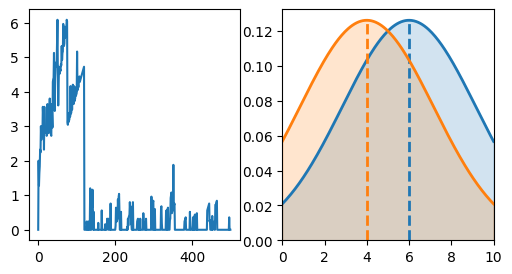

In [ ]:
c_level = 3
regret = [run_sim1(UCB(2, c_level=c_level), mab, step_num=500) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

## 4
simulation below assumes a non-stationary multi-armed bandit. specifically in this simulation mean value of distribution of first arm changes in step 100. describe the result of thompson sampling.

In [ ]:
def run_sim2(ts, mab, step_num=200, change_step=100):
    init_mean = mab[0].mean
    best_mean = np.max([b.mean for b in mab])
    regret = []
    cum_rewards = 0 
    for i in range(step_num):
        if i == change_step:
            mab[0].mean = 2
            best_mean = np.max([b.mean for b in mab])
        idx = ts.select_arm(i)
        arm = mab[idx]
        reward = arm.sample()
        ts.update(idx, reward)
        cum_rewards += reward
        regret.append(best_mean*(i+1)-cum_rewards)
            
                  
        # ==================================== Your Code (Begin) ==================================
        
        # run tompson sampling algorithm and return cumulative regret
        
        # ==================================== Your Code (End) ====================================
    mab[0].mean = init_mean
    return regret

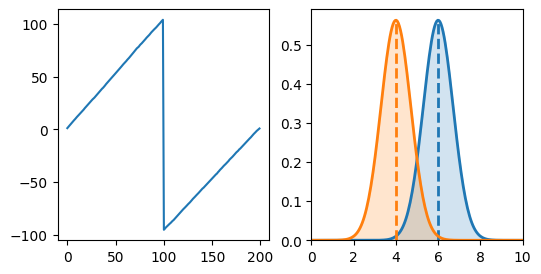

In [ ]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(ThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)

### 4.1
change thompson sampling algorithm to improve results in non-stationary MAB.

In [ ]:
class NewThompsonSampling:
    def __init__(self, var_list, buffer_size=30, **kwargs):
        self.var_list = var_list 
        self.buffer_size = buffer_size
        self.rewards = [0] * len(var_list)
        self.visited = [0] * len(var_list)
        self.buffer = []

    def select_arm(self, *args):
        # ==================================== Your Code (Begin) ==================================
        
        # select arm based on estimate of prior distribution
        samples = []
        for i in range(len(self.var_list)):
            mean, var = self._posterior(i)
            samples.append(np.random.normal(mean, np.sqrt(var)))
        return np.argmax(samples)
        # return index of selected arm

        # ==================================== Your Code (End) ====================================

    def update(self, idx, reward):
        # ==================================== Your Code (Begin) ==================================
        self.visited[idx] += 1
        self.rewards[idx] += reward
        self.buffer.append((idx, reward))
        if len(self.buffer) > self.buffer_size:
            idx, reward = self.buffer.pop(0)
            self.visited[idx] -= 1
            self.rewards[idx] -= reward
        # update prior based on reward
        
        # ==================================== Your Code (End) ====================================
        pass

    def _posterior(self, idx):
        """
        Compute posterior distribution of arm's mean.
        """
        n = self.visited[idx]
        x = self.rewards[idx]
        s2 = self.var_list[idx]
        if n == 0:
            return 0, np.inf
        else:
            mle = x / n
            post_mean = ((self.buffer_size / s2) * mle + (n / s2) * np.mean([self.buffer[i][1] for i in range(len(self.buffer)) if self.buffer[i][0] == idx])) / ((self.buffer_size / s2) + (n / s2))
            post_var = 1 / ((self.buffer_size / s2) + (n / s2))
            return post_mean, post_var

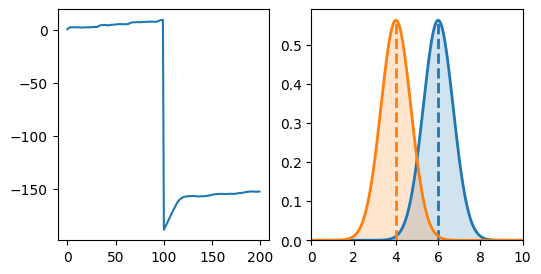

In [ ]:
mab = [Arm(6, 0.5), Arm(4, 0.5)]
regret = [run_sim2(NewThompsonSampling([b.var for b in mab]), mab) for _ in range(50)]
plot(np.mean(regret, axis=0), mab)